# N Gram Language model


- Generate text and complete queries from sequences of n-grams, using temperature sampling to tune the randomness of the generated text.
- Calculate the probability of a sentence and select the most probable sentence among several candidates.
- Score the quality of the language model using perplexity.
- Handle out-of-vocabulary (OOV) tokens with Laplace smoothing.


## Data structure

We want to avoid having to build and keep in memory a large matrix of all the prefixes and all the tokens in the corpus. Such a matrix would also be mostly filled with zeroes.

The choice of an optimal and efficient data structure is up to you. However, we have found that using a defaultdict(Counter) is quite efficient for avoiding the need to keep in memory a very large matrix of all the prefixes and all the tokens in the corpus.

That data structure will have existing prefixes (tuples) as keys of the defaultdict and a list of tokens and their respective frequencies as the Counter dictionary.

For instance, see the following examples:

    freq = defaultdict(Counter)
    freq[('how', 'many')] = Counter('people': 0.56, 'times': 0.31, 'does': 0.02, ...)
    freq[('the','model')] = Counter('parameters': 0.43, '.': 0.21, 'is': 0.08, ....)



## Workflow

1. Split the dataset into a training and a testing subset. Use the category “title” for the testing set and the categories “comment” and “post” for the training set. The short length of titles will make them good candidates later as seeds for text generation. 

2. Build the matrix of prefix—word frequencies.
- Use the ngrams function from nltk.utils to generate all n-grams from the corpus.
- Set the following: left_pad_symbol = <s> and right_pad_symbol = </s>.


3. Write a text generation function with the following features:
- Takes a bigram as input and generates the next token
- Iteratively slides the prefix over the generated text so that the new prefix includes the most recent token; generates the next token
- To generate each next token, samples the list of words associated with the prefix using the probability distribution of the prefix
- Stops the text generation when a certain number of words have been generated or the latest token is a </s>

4. Write a function that can estimate the probability of a sentence and use it to select the most probable sentence out of several candidate sentences.
- Split the sentence into trigrams and use the chain rule to calculate the probability of the sentence as a product of the bigrams—tokens probabilities.

5. Implement the perplexity scoring function for a given sentence and for the training corpus.

6. Implement additive Laplace smoothing to give a non-zero probability to missing prefix—token combinations when calculating perplexity.

7. Calculate the perplexity of the language model on the test set composed of titles.

8. Try to improve the perplexity score of your model as follows:
- Modify the preprocessing phase of the corpus.
- Increase or decrease the number of tokens in the model (bigrams, 4-grams, and so on).
- Vary the delta parameter in the additive Laplace smoothing step

In [1]:
# We will work with trigrams 
ngrams_degree = 3

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("stackexchange_812k.tokenized.csv").sample(frac=1, random_state=8).reset_index(drop=True)

In [4]:
df.sample(3)

,post_id,parent_id,comment_id,text,category,tokens,n_tokens
43326,185764,NaN,NaN,"Check predicted Data by observed Data, how goo...",title,"check predicted data by observed data , how go...",14
381692,362578,NaN,681147.0,Thanks for the answer! Regarding the question ...,comment,thanks for the answer ! regarding the question...,115
536791,165071,NaN,488767.0,Discriminate models do not have an inherent wi...,comment,discriminate models do not have an inherent wi...,96


In [5]:
df['tokens'] = df.tokens.apply(lambda txt : txt.split())

In [6]:
df.sample(3)

,post_id,parent_id,comment_id,text,category,tokens,n_tokens
135039,155702,NaN,296806.0,"Just a nitpicky thing, but what is returned by...",comment,"[just, a, nitpicky, thing, ,, but, what, is, r...",29
127186,257166,NaN,491280.0,How much RAM do you have on your machine?,comment,"[how, much, ram, do, you, have, on, your, mach...",10
728474,137008,NaN,261063.0,I would like to have more information too but ...,comment,"[i, would, like, to, have, more, information, ...",52


In [7]:
split_index = int(len(df) * 0.8)
df_train = df[df.category.isin(['post', 'comment'])].copy()
df_test = df[df.category.isin(['title'])].copy()

In [8]:
# Display the dimensions of the dataframe 
print("-- Training set: {}\n".format(df_train.shape))
# and the 1st 5 lines
print(df_train.head())

print("\n-- Testing set {}\n".format(df_test.shape))
print(df_test.head())

-- Training set: (705964, 7)

   post_id  parent_id  comment_id  \
0   161009        NaN    309845.0   
1    77562        NaN         NaN   
2    96622    96351.0         NaN   
3   299263        NaN         NaN   
4   168874   162942.0         NaN   

                                                text category  \
0  I can't disclose the algorithm, but I can cert...  comment   
1  I just discovered by mistake that raw data and...     post   
2  Even though this question already has an accep...     post   
3  When you toss a coin, say, times, are there tw...     post   
4  Your approaches boil down to one single underl...     post   

                                              tokens  n_tokens  
0  [i, can, ', t, disclose, the, algorithm, ,, bu...        40  
1  [i, just, discovered, by, mistake, that, raw, ...        81  
2  [even, though, this, question, already, has, a...       829  
3  [when, you, toss, a, coin, ,, say, ,, times, ,...        66  
4  [your, approaches, boil, dow

In [9]:
from nltk import ngrams
from collections import defaultdict, Counter
from tqdm import tqdm

counts = defaultdict(Counter)

for tokens in tqdm(df_train.tokens.values):
    for ngram in ngrams(
          tokens, 
          n= ngrams_degree,  
          pad_right=True, 
          pad_left=True, 
          left_pad_symbol="<s>", 
          right_pad_symbol="</s>"):
      
        prefix = ngram[:ngrams_degree-1]
        token = ngram[ngrams_degree-1]
        counts[prefix][token] +=1

100%|██████████| 705964/705964 [01:16<00:00, 9202.03it/s] 


In [10]:
print("we have {} bigrams".format(len(counts.keys())))

we have 3315978 bigrams


In [11]:
import random

for i in range(5):
    prefix = random.choice(list(counts.keys()))
    print("{}: \t{}".format(prefix,counts[prefix]))

('tongues', 'tougher'): 	Counter({'or': 1})
('religion', 'it'): 	Counter({"'": 1})
('letter', 'subscript'): 	Counter({'with': 1})
('guitar', 'in'): 	Counter({'an': 1})
('the', 'cvs'): 	Counter({',': 1, 'of': 1, 'were': 1, '.': 1, 'so': 1, 'to': 1})


In [12]:
tokens_count = [ len(v)   for k,v in counts.items() ]

(array([3.303251e+06, 7.750000e+03, 2.285000e+03, 9.900000e+02,
        5.560000e+02, 3.170000e+02, 2.210000e+02, 1.410000e+02,
        1.030000e+02, 7.400000e+01, 5.100000e+01, 2.800000e+01,
        2.400000e+01, 2.500000e+01, 2.400000e+01, 1.500000e+01,
        2.000000e+01, 9.000000e+00, 1.800000e+01, 7.000000e+00,
        5.000000e+00, 7.000000e+00, 2.000000e+00, 4.000000e+00,
        2.000000e+00, 3.000000e+00, 2.000000e+00, 3.000000e+00,
        5.000000e+00, 3.000000e+00, 4.000000e+00, 3.000000e+00,
        1.000000e+00, 3.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 3.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 0.000000e+00, 1.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        2.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 2.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.00

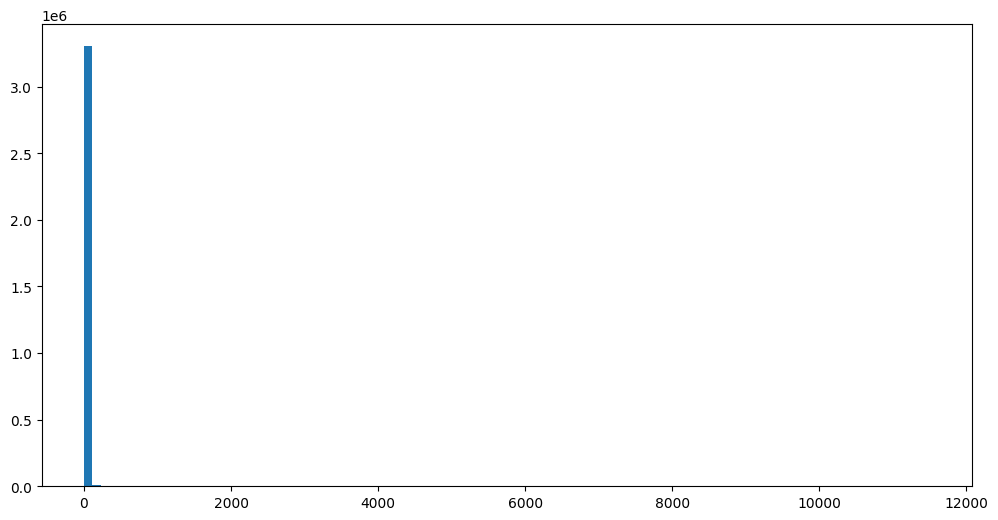

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(12,6))
plt.hist(tokens_count, bins = 100)

In [14]:
bigrams_with_single_tokens = [ k   for k,v in counts.items() if len(v) == 1 ]
bigrams_with_two_tokens = [ k   for k,v in counts.items() if len(v) == 2 ]

print("{} bigrams_with_single_tokens".format(len(bigrams_with_single_tokens)))
print("{} bigrams_with_two_tokens".format(len(bigrams_with_two_tokens)))

2132871 bigrams_with_single_tokens
444606 bigrams_with_two_tokens


In [15]:
tokens_dict = { k:len(v)   for k,v in counts.items() if len(v) > 10000 }
tokens_dict

{('<s>', '<s>'): 11497, ('of', 'the'): 10786}

$$p(\text{token}/\text{prefix}) = \frac{\text{count}(\text{prefix}+\text{token})}{\text{count}(\text{prefix})}$$

In [16]:
freq = defaultdict(dict)
for prefix, tokens in counts.items():
    total = sum( counts[prefix].values()  )
    for token, c in tokens.items():
        freq[prefix][token] = c / total

In [17]:
for i in range(5):
    prefix = random.choice(list(freq.keys()))
    print("{}: \t{}".format(prefix,freq[prefix]))

('f', 'notf'): 	{'.': 1.0}
('t', 'coefficients'): 	{'essentially': 0.25, 'be': 0.25, 'beta': 0.25, 'intercept': 0.25}
('eye', 'len'): 	{'beta': 0.6666666666666666, 'labels': 0.3333333333333333}
('what', 'place'): 	{'each': 0.5, 'for': 0.5}
('zones', 'being'): 	{'so': 1.0}


In [20]:
import numpy as np

def generate(text, n_words=40):
    global ngrams_degree
    for i in range(n_words):
        prefix = tuple(text.split()[-ngrams_degree+1:])
        # no available text
        if len(freq[prefix]) == 0:
            break
        candidates = list(freq[prefix].keys())
        probas = list(freq[prefix].values())
        text += ' ' + np.random.choice(candidates, p = probas)
        if text.endswith('<\s>'):
            break

    return text

In [23]:
text      = 'the model'
print()
print(generate(text))

print()
text      = 'that distribution'
print(generate(text))

print()
text      = 'to determine'
print(generate(text))


the model ' s of thousands of variables , and this lecture notes . i should not be there is a case that is left is stationary because arima is not necessarily an issue , i ' m absolutely happy to know

that distribution change with varying window size window and the latter , provided there is no generally accepted idea . given this , first in the light disappears . if you ' re asking it here . </s> </s>

to determine the entrees for the clarification . </s> </s>
